In [1]:
# This project is to find the lane lines with advanced method
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Undistort the image

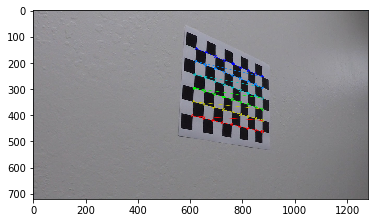

In [2]:
# read in the calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# array to store all the object points and image points
objpoints = [] # 3D points in real world
imgpoints = [] # 2D points in image plane

objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image_name in images:
    # read in each image
    img = mpimg.imread(image_name)
    
    # conver img to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find chess board corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
    #plt.imshow(gray,cmap='gray')
    
    #If corners are found, add image points and object points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # draw the corners and display
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        
# calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# Perspective Transform

In [3]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    # compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # compute the inverse perspective transform, just swap the input
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, M, Minv

# Color threshold

In [4]:
# Convert to HLS space and extract S and L channel
def select_color_channel(img_undistort):
    hls = cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Threshold s channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    ls_binary = np.zeros_like(s_channel)
    ls_binary[(s_binary == 1) | (l_binary == 1)] = 1
    
    return ls_binary

# Gradient Selection

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scale_abs_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scale_abs_sobel)
    binary_output[(scale_abs_sobel >= thresh[0]) & (scale_abs_sobel <= thresh[1])] = 1
      
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_abs_sobelxy = np.uint8(255 * abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_abs_sobelxy)
    binary_output[(scaled_abs_sobelxy >= mag_thresh[0]) & (scaled_abs_sobelxy <= mag_thresh[1])] = 1
    
    return binary_output

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
   
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    direct = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direct)
    binary_output[(direct >= thresh[0]) & (direct <= thresh[1])] = 1
    return binary_output

In [8]:
def calculate_gradient(image):
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 120))
    dir_binary = dir_threshold(image, sobel_kernel=3, thresh=(0.3, 0.8))
    
    gradient_combined = np.zeros_like(dir_binary)
    gradient_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return gradient_combined

# Search the lane lines

In [9]:
# look for the lane lines and denote them with green lanes 
def look_for_lane_lines(dst, NWINDOWS = 3):
    histogram = np.sum(dst[dst.shape[0]//2:,:], axis=0)
    out_img = np.dstack((dst,dst,dst))*255
    midpoint = np.int(len(histogram)/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = NWINDOWS
    window_height = np.int(dst.shape[0]/nwindows)
    nonzero = dst.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    # set the width of the window ( +/- margin )
    margin = 100

    # set the minium number of pixels found to recenter window
    minpix = 50

    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one

    for window in range(nwindows):
        # identify the positions of the left and right windows
        win_y_low = dst.shape[0] - (window + 1)* window_height
        win_y_high = dst.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),(win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),(win_xright_high, win_y_high),(0, 255, 0), 2)

        # Indentify the nonzero pixels in x and y within the left and right windows
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_curverad, right_curverad = radius_of_curvature(dst,leftx,lefty,rightx,righty)
    offset = offset_lane(dst,leftx,lefty,rightx,righty)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, left_curverad, right_curverad, offset


In [10]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

def look_for_lane_lines2(dst, left_fit, right_fit):

    nonzero = dst.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curverad, right_curverad = radius_of_curvature(dst,leftx,lefty,rightx,righty)
    offset = offset_lane(dst,leftx,lefty,rightx,righty)

    return left_fit, right_fit, left_lane_inds, right_lane_inds, left_curverad, right_curverad, offset


# Calculate the Radius of the Curvature

In [11]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def radius_of_curvature(dst,leftx,lefty,rightx,righty):
 
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    #print('The difference between np.max(lefty) - np.max(righty)', np.max(lefty) - np.max(righty))
    y_eval = dst.shape[0]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the offset of the lane

In [12]:
def offset_lane(dst,leftx,lefty,rightx,righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension

    # the bottem value of y
    y_eval = dst.shape[0]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    x_bot_left = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_bot_right = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    x_mid_lane = np.round((x_bot_left + x_bot_right)/2)
    
    x_mid_img = np.floor(dst.shape[1]/2)
    
    # positive: vehicle left offset, negative: right offset
    offset = xm_per_pix * (x_mid_lane - x_mid_img) 
    
    return offset
    
    

In [13]:
# Create an image to draw on and an image to show the selection window
def plot_lane_lines(dst, left_lane_inds, right_lane_inds, left_fit, right_fit):
    
    nonzero = dst.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    ploty = np.linspace(0, dst.shape[0]-1, dst.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((dst, dst, dst))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    
    return window_img

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
from scipy import misc

In [15]:
flag = 0
left_fit_all = []
right_fit_all = []

# Create the pipeline

In [ ]:
def pipeline(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # undistort the input image
    global mtx, dist, flag, left_fit, right_fit
    global left_fit_all, right_fit_all
    img_undistort = cv2.undistort(image, mtx, dist, None, mtx)
    
    # select s and l channel
    ls_binary = select_color_channel(img_undistort)
    
    # calculate the gradient 
    sxbinary = calculate_gradient(img_undistort)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(ls_binary == 1) | (sxbinary == 1)] = 1
    
    # Do the perspective transform
    dst, M, Minv = warp(combined_binary)
    
    if flag == 0:
        left_fit, right_fit, left_lane_inds, right_lane_inds ,left_curverad, right_curverad, offset = look_for_lane_lines(dst, NWINDOWS = 3)
        flag = flag + 1
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds ,left_curverad, right_curverad, offset = look_for_lane_lines2(dst, left_fit, right_fit)
        flag = flag + 1
    
    left_fit_all.append(left_fit)
    right_fit_all.append(right_fit)
    # average the fitting from previous fittings
    if flag >= 10:
        left_fit = np.average(left_fit_all[-10:], axis = 0)
        right_fit = np.average(right_fit_all[-10:], axis = 0)
        
    # add radius of curvature and offset to the image
    string_left_curve = 'Left Radius of Curvature = ' + str(round(left_curverad)) + ' (m)'
    string_right_curve = 'Right Radius of Curvature = ' + str(round(right_curverad)) + ' (m)'
    
    if offset > 0:
        string_offset = 'Vehicle is ' + str(round(offset,2)) + ' (m) left of center'
    elif offset < 0:
        string_offset = 'Vehicle is ' + str(round(abs(offset),2)) + ' (m) right of center'
    else:
        string_offset = 'Vehicle is in the middle of the lane'
    
    img_undistort= cv2.putText(img_undistort,string_left_curve, (100, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)
    img_undistort= cv2.putText(img_undistort,string_right_curve, (100, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)
    img_undistort= cv2.putText(img_undistort,string_offset, (100, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)

        
    window_img = plot_lane_lines(dst, left_lane_inds, right_lane_inds, left_fit, right_fit)
    img_size = (img_undistort.shape[1], img_undistort.shape[0])
    inv_warped = cv2.warpPerspective(window_img, Minv, img_size, flags = cv2.INTER_LINEAR)
    result = cv2.addWeighted(img_undistort, 1, inv_warped, 0.3, 0, dtype = 0)
    
    return result

In [ ]:
white_output = 'project_video_submit.mp4'
clip1 = VideoFileClip('./project_video.mp4')#.subclip(37,42)  #challenge_video,  project_video
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_submit.mp4
[MoviePy] Writing video project_video_submit.mp4


100%|█████████▉| 1257/1261 [04:19<00:00,  5.11it/s]

In [ ]:
flag = 0
img = mpimg.imread('./test_images/test3.jpg')
example_output = pipeline(img)
f, ax1 = plt.subplots(1,1,figsize = (40,20))
ax1.imshow(example_output)
#plt.savefig('./submit_to_github/my_p4_examples/example_output.jpg')
